In [240]:

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as pyoff

import warnings
warnings.filterwarnings("ignore")


pyoff.init_notebook_mode(connected=True)
#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split


In [241]:
# !pip install chart-studio


In [255]:

df= pd.read_csv('/kaggle/input/combine-dataset-2009-2011/combine_dataset_2009_2011.csv')

df = df.drop(["Invoice","Description","Year","Customer ID","Country"],axis=1)
df=df[(df["StockCode"]==10002)&(df["Quantity"]>0)&(df["Price"]>0)]
df.head(10)

,StockCode,Quantity,InvoiceDate,Price
35,10002,12,2009-12-01 09:08:00,0.85
6127,10002,1,2009-12-03 13:49:00,0.85
6139,10002,1,2009-12-03 13:49:00,0.85
7487,10002,1,2009-12-03 19:13:00,0.85
7584,10002,4,2009-12-03 20:03:00,0.85
7683,10002,12,2009-12-04 08:46:00,0.85
8479,10002,12,2009-12-04 12:20:00,0.85
8942,10002,48,2009-12-04 13:47:00,0.85
9578,10002,1,2009-12-04 17:31:00,0.85
10180,10002,48,2009-12-06 11:57:00,0.85


In [256]:
df['total_price'] = df['Quantity']*df['Price']
df

,StockCode,Quantity,InvoiceDate,Price,total_price
35,10002,12,2009-12-01 09:08:00,0.85,10.20
6127,10002,1,2009-12-03 13:49:00,0.85,0.85
6139,10002,1,2009-12-03 13:49:00,0.85,0.85
7487,10002,1,2009-12-03 19:13:00,0.85,0.85
7584,10002,4,2009-12-03 20:03:00,0.85,3.40
...,...,...,...,...,...
569270,10002,120,2011-04-01 11:10:00,0.85,102.00
570273,10002,4,2011-04-03 11:36:00,0.85,3.40
570663,10002,2,2011-04-03 15:07:00,0.85,1.70
583249,10002,62,2011-04-15 12:14:00,0.85,52.70


In [258]:
#represent month in date field as its first day
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = df['InvoiceDate'].dt.year.astype('str') + '-' + df['InvoiceDate'].dt.month.astype('str') + '-01'
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
#groupby date and sum the sales
df = df.groupby('InvoiceDate').total_price.sum().reset_index()

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceDate  17 non-null     datetime64[ns]
 1   total_price  17 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 400.0 bytes


In [260]:
df

,InvoiceDate,total_price
0,2009-12-01,186.15
1,2010-01-01,248.97
2,2010-02-01,220.07
3,2010-03-01,493.94
4,2010-04-01,843.73
5,2010-05-01,1157.49
6,2010-06-01,404.20
7,2010-07-01,416.49
8,2010-08-01,450.15
9,2010-09-01,215.42


In [261]:
plot_data = [
    go.Scatter(
        x=df['InvoiceDate'],
        y=df['total_price'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [262]:
df_diff = df.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['total_price'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['total_price'] - df_diff['prev_sales'])
df_diff.head(10)

,InvoiceDate,total_price,prev_sales,diff
1,2010-01-01,248.97,186.15,62.82
2,2010-02-01,220.07,248.97,-28.90
3,2010-03-01,493.94,220.07,273.87
4,2010-04-01,843.73,493.94,349.79
5,2010-05-01,1157.49,843.73,313.76
6,2010-06-01,404.20,1157.49,-753.29
7,2010-07-01,416.49,404.20,12.29
8,2010-08-01,450.15,416.49,33.66
9,2010-09-01,215.42,450.15,-234.73
10,2010-10-01,794.82,215.42,579.40


In [263]:
#plot sales diff
plot_data = [
    go.Scatter(
        x=df_diff['InvoiceDate'],
        y=df_diff['diff'],
    )
]
plot_layout = go.Layout(
        title='Montly Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [264]:
df_diff.head()

,InvoiceDate,total_price,prev_sales,diff
1,2010-01-01,248.97,186.15,62.82
2,2010-02-01,220.07,248.97,-28.90
3,2010-03-01,493.94,220.07,273.87
4,2010-04-01,843.73,493.94,349.79
5,2010-05-01,1157.49,843.73,313.76


In [266]:
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised

,InvoiceDate,total_price,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2011-01-01,291.37,-94.43,-369.39,-39.63,579.40,-234.73,33.66,12.29,-753.29,313.76,349.79,273.87,-28.90,62.82
1,2011-02-01,45.76,-245.61,-94.43,-369.39,-39.63,579.40,-234.73,33.66,12.29,-753.29,313.76,349.79,273.87,-28.90
2,2011-03-01,27.70,-18.06,-245.61,-94.43,-369.39,-39.63,579.40,-234.73,33.66,12.29,-753.29,313.76,349.79,273.87
3,2011-04-01,160.65,132.95,-18.06,-245.61,-94.43,-369.39,-39.63,579.40,-234.73,33.66,12.29,-753.29,313.76,349.79


In [267]:
df_supervised.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceDate  4 non-null      datetime64[ns]
 1   total_price  4 non-null      float64       
 2   diff         4 non-null      float64       
 3   lag_1        4 non-null      float64       
 4   lag_2        4 non-null      float64       
 5   lag_3        4 non-null      float64       
 6   lag_4        4 non-null      float64       
 7   lag_5        4 non-null      float64       
 8   lag_6        4 non-null      float64       
 9   lag_7        4 non-null      float64       
 10  lag_8        4 non-null      float64       
 11  lag_9        4 non-null      float64       
 12  lag_10       4 non-null      float64       
 13  lag_11       4 non-null      float64       
 14  lag_12       4 non-null      float64       
dtypes: datetime64[ns](1), float64(14)
memory usage: 608.0 bytes


In [268]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

-0.39980696238748514


In [273]:
df_supervised.shape

(4, 15)

In [274]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['total_price','InvoiceDate'],axis=1)
#split train and test set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_model, test_size=0.2, random_state=42)


In [275]:
train_set

,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
3,132.95,-18.06,-245.61,-94.43,-369.39,-39.63,579.40,-234.73,33.66,12.29,-753.29,313.76,349.79
0,-94.43,-369.39,-39.63,579.40,-234.73,33.66,12.29,-753.29,313.76,349.79,273.87,-28.90,62.82
2,-18.06,-245.61,-94.43,-369.39,-39.63,579.40,-234.73,33.66,12.29,-753.29,313.76,349.79,273.87


In [276]:
test_set

,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
1,-245.61,-94.43,-369.39,-39.63,579.4,-234.73,33.66,12.29,-753.29,313.76,349.79,273.87,-28.9


In [278]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)  

# Convert to NumPy array and reshape
train_set = train_set.to_numpy() 
test_set = test_set.to_numpy()    

train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [282]:
train_set_scaled

array([[ 1.        ,  1.        , -1.        , -0.42039861, -1.        ,
        -1.        ,  1.        ,  0.31789821, -0.85822802,  0.38807702,
        -1.        ,  0.80971243,  1.        ],
       [-1.        , -1.        ,  1.        ,  1.        , -0.18328481,
        -0.76321018, -0.39316817, -1.        ,  1.        ,  1.        ,
         0.92523312, -1.        , -1.        ],
       [-0.32826106, -0.29536333,  0.46790951, -1.        ,  1.        ,
         1.        , -1.        ,  1.        , -1.        , -1.        ,
         1.        ,  1.        ,  0.47088546]])

In [283]:
test_set_scaled

array([[-2.32975636,  0.56525204, -2.20186426, -0.30488306,  4.75442746,
        -1.63034102, -0.34067041,  0.94568905, -6.07897967,  0.93467382,
         1.06753198,  0.59903879, -1.63923058]])

In [279]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [281]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(4, input_shape=(X_train.shape[1], X_train.shape[2]), stateful=False))  # Change here
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)  # Fix deprecated `nb_epoch`


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0557  
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0358 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0205 
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0060 
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9920 
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9783 
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9649 
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9518 
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9390 
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9264 
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9140 
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9018 
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8899 
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8781 
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8665 
Epoch 16/100
3/3 ━

In [284]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


In [285]:
y_pred

array([[-0.07060547]], dtype=float32)

In [286]:
y_test

array([[-2.32975636]])

In [288]:
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[-0.07060547  0.56525204 -2.20186426 -0.30488306  4.75442746 -1.63034102
  -0.34067041  0.94568905 -6.07897967  0.93467382  1.06753198  0.59903879
  -1.63923058]]


In [291]:
result_list = []
sales_dates = list(df[-7:].InvoiceDate)
act_sales = list(df[-7:].total_price)

In [292]:
#create dataframe that shows the predicted sales
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['InvoiceDate'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

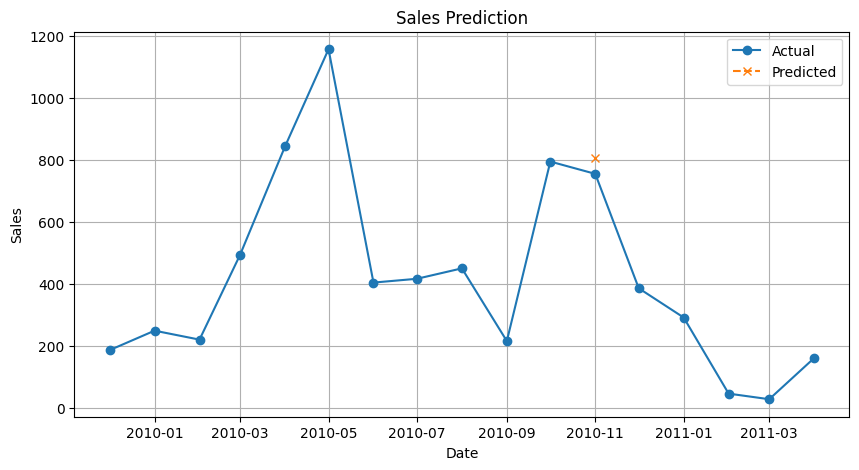

In [293]:
import matplotlib.pyplot as plt

# Merge actual sales with predictions
df_sales_pred = pd.merge(df, df_result, on='InvoiceDate', how='left')

# Plot actual vs predicted sales
plt.figure(figsize=(10, 5))
plt.plot(df_sales_pred['InvoiceDate'], df_sales_pred['total_price'], label='Actual', marker='o')
plt.plot(df_sales_pred['InvoiceDate'], df_sales_pred['pred_value'], label='Predicted', linestyle='dashed', marker='x')

# Formatting
plt.title('Sales Prediction')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)

# Show plot
plt.show()
